In [1]:
library(e1071)
library(ggplot2)

# Naive Bayes classification

In this practical, you will implement Naive Bayes classification for a particular dataset, using both plug-in estimates and a fully Bayesian method. There are built-in functions for doing this in R, but here you are being asked to implement this yourself, including working out some of the theory. 

The task is to classify Iris plants into species, based on four measurements of the flower. The available data set for training and testing is the well-known Iris dataset. You can read it in from the files 'iris_train.csv' and 'iris_test.csv'. 

In [2]:
trainD <- read.csv('iris_train.csv')
testD <- read.csv('iris_test.csv')

Display the first six rows of the training set using the `head` function to see the structure of the dataset. 

In [3]:
head(trainD)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,4.7,3.2,1.3,0.2,setosa
2,5.0,3.6,1.4,0.2,setosa
3,5.4,3.9,1.7,0.4,setosa
4,4.6,3.4,1.4,0.3,setosa
5,4.9,3.1,1.5,0.1,setosa
6,5.4,3.7,1.5,0.2,setosa


The feature vectors in this dataset are points in $x\in\mathbb{R}^{4}$, i.e.\ they are made up of four $\mathbb{R}$-valued features. You can use the `pairs` function to produce multiple scatterplots of two of these features at a time, coloured by species, or `ggplot` to produce histograms of each feature coloured with respect to species. You could also make similarly informative plots in many other ways. Produce some such plots to get an idea of the structure of the data set. 

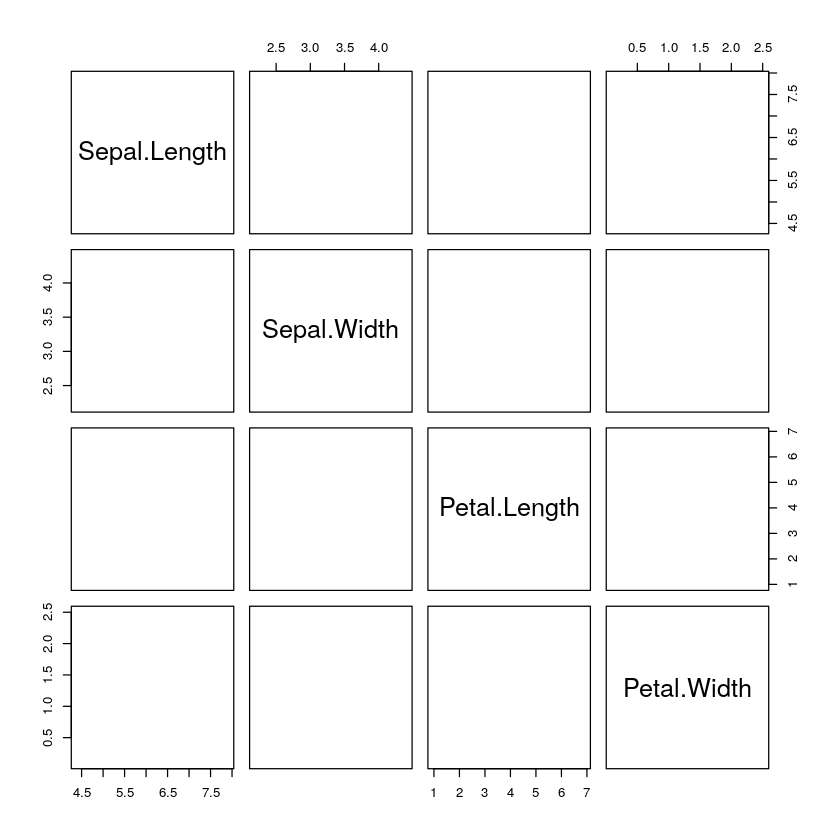

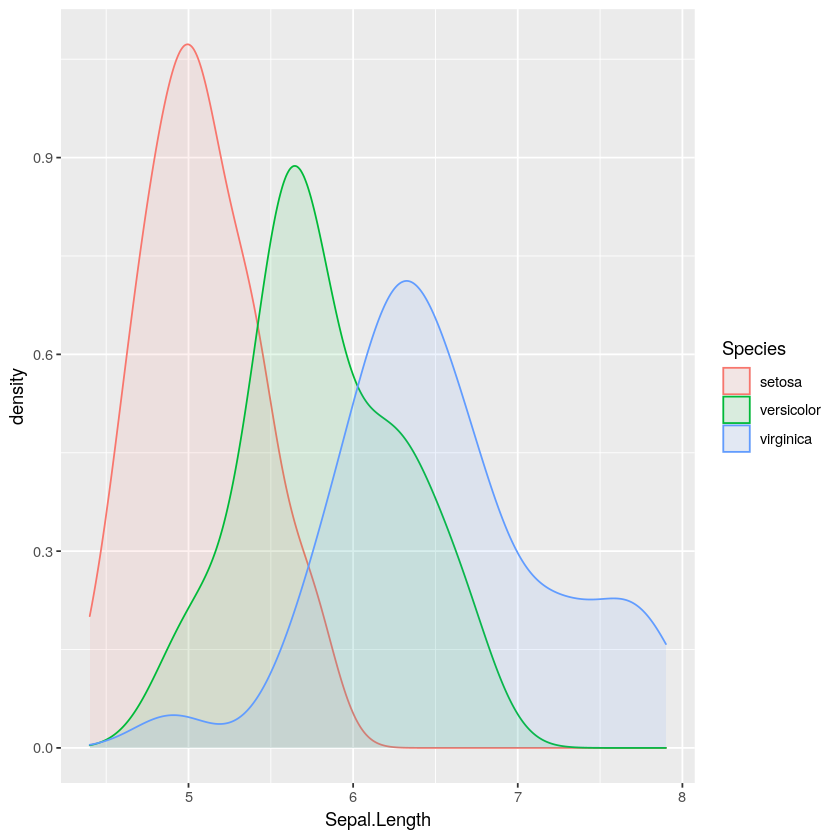

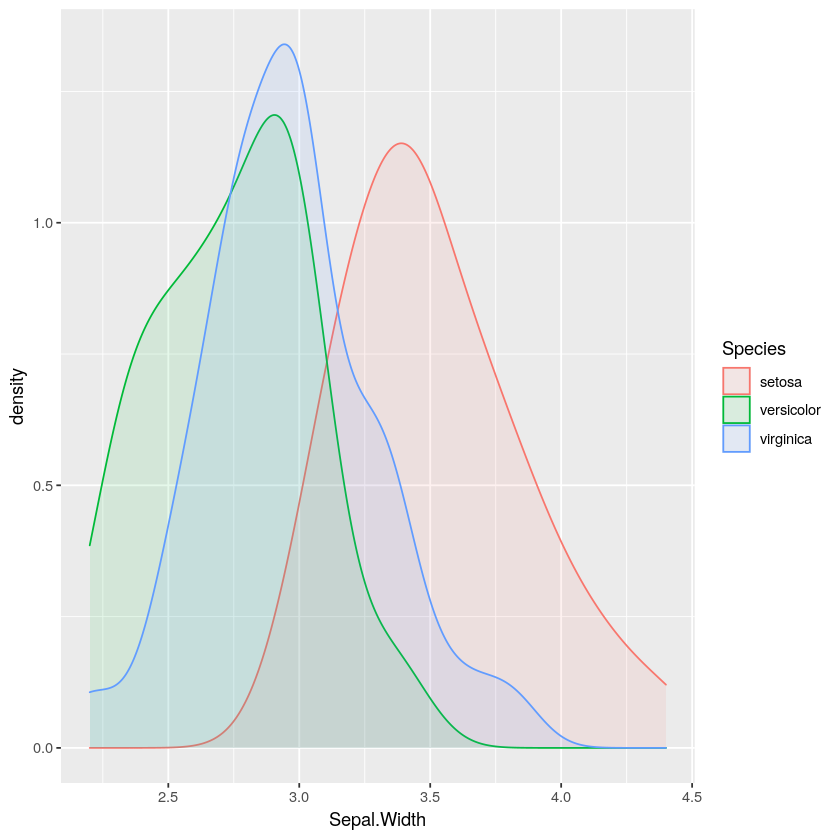

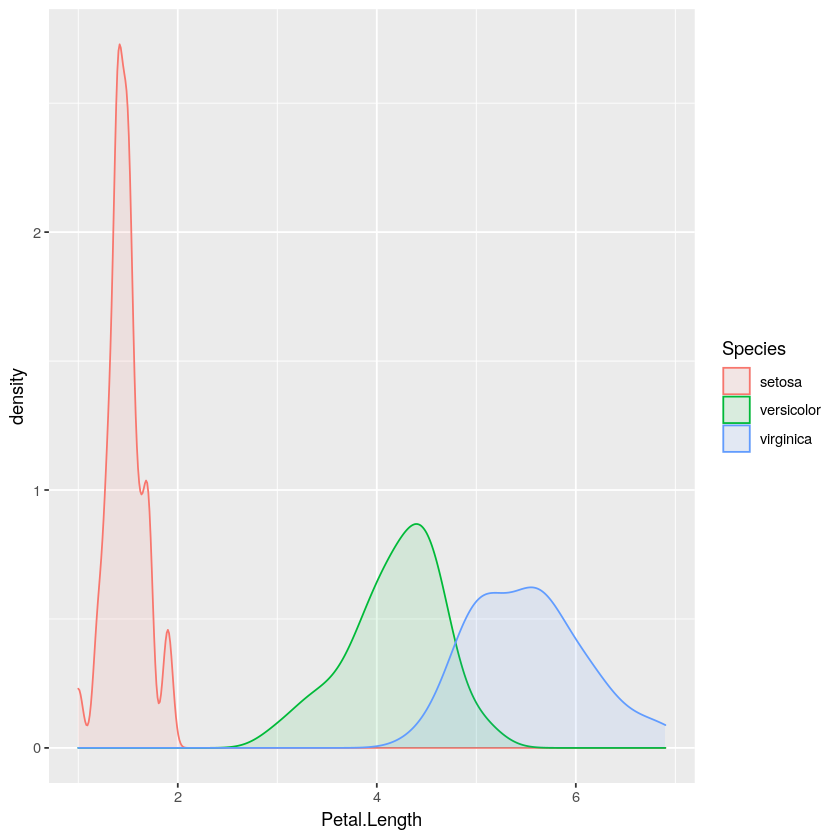

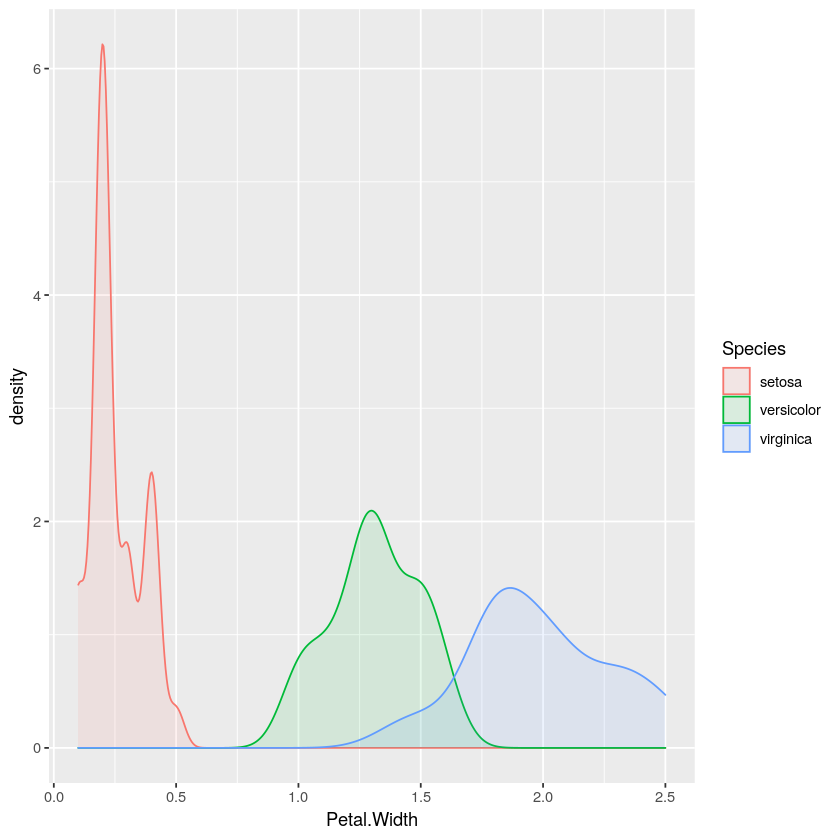

In [4]:
myCols <- c('red', 'green3', 'blue')

pairs(trainD[,-5], col=myCols[trainD$Species])

ggplot(trainD, aes(Sepal.Length, fill = Species, colour = Species)) +
  geom_density(alpha = 0.1)

ggplot(trainD, aes(Sepal.Width, fill = Species, colour = Species)) +
  geom_density(alpha = 0.1)

ggplot(trainD, aes(Petal.Length, fill = Species, colour = Species)) +
  geom_density(alpha = 0.1)

ggplot(trainD, aes(Petal.Width, fill = Species, colour = Species)) +
  geom_density(alpha = 0.1)

Note several things.

- Features can seem very correlated when not conditioned on class (i.e. ignoring the colours), for example petal width and petal length. While there is still correlation when we condition on class (i.e. look at one colour at a time), it is much reduced. 

- The density plots of the individual features are mostly unimodal (one peak), and although not exactly Gaussian, they are not far off. The question is, if we took another sample, could we expect them to preserve these features, or would it really be just the mean and variance that were approximately the same each time? If the former, then we might think twice about using a Gaussian model, especially for the bimodal cases (e.g. sepal length for virginica). If the latter, then by maximum entropy, we should choose a Gaussian. The latter is more robust. 

We have to choose an appropriate model $P(x \mid \theta_{c}, K)$ for these feature vectors. The Naive Bayes assumption means that we can choose distributions on each feature separately without having to worry about dependencies: $P(x_{a} \mid \theta_{ca}, K)$; and then multiply them together. We will use Gaussian distributions with means $\mu_{ca}$ and variances $v_{ca}$ for each class and feature:

$$
P(x_{a} \mid \mu_{ca}, v_{ca}, K) = {1 \over \sqrt{2\pi v_{ca}}}\exp\Bigl(-{1\over 2v_{ca}}(x_{a} - \mu_{ca})^{2}\Bigr)
$$

where $\exp(x) = e^{x}$.

## Plug-in estimates

We start by calculating the plug-in estimates of the parameters. Recall that this results from an approximation of the integral over the parameters. The parameters in this problem are the $\pi_{c}$ and the $\theta_{ca} = (\mu_{ca}, v_{ca})$. For the former, the formula for the estimate is 

$$
\hat{\pi}_{c} = N_{c} / N
$$

where $N_{c}$ is the number of instances of class $c$ in the training data, and $N$ is the total number of instances.

To estimate the $\theta_{ca}$, you have to work out the expression in the lecture notes in this case:

$$
\hat{\theta}_{ca} = \arg\max_{\theta_{ca}} \sum_{i:c_{i} = c} L(x_{ia} \mid \theta_{ca}, K) 
$$

where $L = \ln P$. You can use the cell below to record your answer in Latex, but feel free to calculate on paper. You will see that the answers are the usual intuitive ones for the mean and variance. 

The formula in the notes for the parameter estimates, repeated above, becomes, once we substitute the specific Gaussian distribution:

$$
\begin{align*}
\hat{\theta}_{ca} 
& = -\arg\max_{\theta_{ca}} \sum_{i:c_{i} = c} \biggl({1 \over 2}\ln(2\pi v_{ca}) + {1\over 2v_{ca}}(x_{ia} - \mu_{ca})^{2}\biggr) \\
& = -\arg\max_{\theta_{ca}}  \biggl({N_{c} \over 2}\ln(2\pi v_{ca}) + {1\over 2v_{ca}}\sum_{i:c_{i} = c}(x_{ia} - \mu_{ca})^{2}\biggr) 
\end{align*}
$$

where we used the fact that the first term does not depend on $i$, and so the sum just produces a multiple of the number $N_{c}$ of data elements with class $c$. Differentiating with respect to $\mu_{ca}$ and setting equal to $0$ then gives:

$$
0 = \sum_{i:c_{i} = c} {1\over 2v_{ca}}2(x_{ia} - \hat{\mu}_{ca})
$$

which implies that 

$$
\hat{\mu}_{ca} = {1 \over N_{c}} \sum_{i:c_{i} = c} x_{ia}
$$

i.e. the average of the feature value over all data points with the correct class. Note that we have added the $\hat{\cdot}$ to emphasize that these are the *estimates* produced by, in this case, maximum likelihood (because we have not included any prior), and not the true values. In fact, we have a full distribution over $\mu_{ca}$ and $v_{ca}$ given the data, and we could perform the integration to get the full distribution over the class $c$ rather than perform the plug-in approximation to the integral. 

Similarly, differentiating with respect to $v_{ca}$ and setting equal to $0$ gives

$$
0 = {N_{c} \over 2 \hat{v}_{ca}} - {1\over 2\hat{v}_{ca}^{2}} \sum_{i:c_{i} = c} (x_{ia} - \hat{\mu}_{ca})^{2}
$$

which implies that 

$$
\hat{v}_{ca} = {1 \over N_{c}} \sum_{i:c_{i} = c} (x_{ia} - \hat{\mu}_{ca})^{2}
$$

i.e. the sample variance of the feature values for the data points with class $c$. 

These are very standard results of course, re-derived in this particular context. 

Now write functions to take the matrix of training data and estimate the parameters $\pi_{c}$ and $\theta_{ca}$. Try to do this in as general a way as possible: i.e. if the model changes, you should at most have to re-write the interior of one of the functions. You could assume the data always have the class as the last column. You may find the function `split` useful, although there are other ways to proceed.

In [5]:
estParams = function(trainD){
    
    numCols = ncol(trainD)
    
    classesTrainD = split(trainD, trainD[ , numCols])
    
    numClasses = length(classesTrainD)
    
    pis = estPis(trainD)
    
    params = vector(mode = 'list')
    
    classParams = vector(mode = 'list')
    
    for (cNum in 1:numClasses){
        
        classTrainD = classesTrainD[[cNum]]
        
        thetas = estClassThetas(classTrainD)
        
        classParams$pi = pis[cNum]
        classParams$thetas = thetas
        
        params[[cNum]] = classParams
    }

    return(params)
}

estClassThetas = function(trainD){

    numCols = ncol(trainD)
    
    fVecs = trainD[, 1:(numCols - 1)]
    
    mus = colMeans(fVecs)
    vs = diag(var(fVecs))
    
    thetas = rbind(mus, vs)
        
    return(thetas)
    
}

estPis = function(trainD){
    
    numCols = ncol(trainD)

    numInClasses = table(trainD[, numCols])

    pis = numInClasses / sum(numInClasses)
    
    return(pis)

}

Once you have the plug-in estimates, you can classify the test data. Write a function that takes a feature vector and the parameters, and returns the probabilities for each class. Inside this function, you may want another that returns the probability of a feature vector for a given class, and inside that, a function that returns the probability of a feature for a given class. It is also convenient to work with log probabilities, which prevents the possibility of underflow due to very small values. At the very end, you can substract the mean of the log probabilities (a constant shift, hence a multiplicative factor), exponentiate, and normalize. 

In [6]:
testD[1, -5]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
,<dbl>,<dbl>,<dbl>,<dbl>
1,5.1,3.5,1.4,0.2


In [7]:
computeClassProbs = function(testVec, params){
    
    numClasses = length(params)
    
    
    LclassProbs = vector()
    
    for (cNum in 1:numClasses){

        classParams = params[[cNum]]

        
        LclassProb = computeLClassProb(testVec, classParams)
        #print(testVec)
        
        LclassProbs[cNum] = LclassProb
    }

    
    meanLclassProb = mean(LclassProbs)


    LclassProbs = LclassProbs - meanLclassProb

    
    classProbs = exp(LclassProbs)

    classProbs = classProbs / sum(classProbs)


    return(classProbs)
    
}

computeLClassProb = function(testVec, classParams){
    
    thetas = classParams$thetas
    pi = classParams$pi

    
    # Compute prob of test vector
    LtestVecProb = computeLTestVecProb(testVec, thetas)

    # Include prior probs of classes
    LclassProb = LtestVecProb + log(pi)


    return(LclassProb)
    
}

computeLTestVecProb = function(testVec, thetas){
    
    numFs = length(testVec)

    
    
    LtestVecProb = 0
    
    for (fNum in 1:numFs){
        print(testVec)
        theta = thetas[,fNum]
        f = testVec[fNum]



        
        LfProb = computeLFProb(f, theta)
        
        LtestVecProb = LtestVecProb + LfProb
    }

         
    return(LtestVecProb)
}

computeLFProb = function(f, theta){
    
    mu = theta[1]
    v = theta[2]
    
    LfProb = log(dnorm(as.numeric(f), mean = as.numeric(mu), sd = as.numeric(sqrt(v))))

    
    return(LfProb)
    
}

Now estimate the parameters from `trainD`, and then apply your function to the rows of `testD` to get a matrix of class probabilities for each test feature vector. Calculate the entropy of each the resulting distrubutions: the minimum is $0$ for all probability on one class; the maximum is $\ln C = \ln 3 \simeq 1.1$ for a uniform distribution (try rounding to two decimal places, i.e.\ about $1\%$ accuracy, to aid visualization). 

You can then maximize over probabilities using `which.max`. (Use the function `apply` to apply a function to all rows of a table.) 

In [10]:
testD[testNum, -5]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
,<dbl>,<dbl>,<dbl>,<dbl>
45,6.3,2.5,5,1.9


# params = estParams(trainD)

numClasses = length(params)

numTests = nrow(testD)

testClassProbs = matrix(0, numTests, numClasses)

for(testNum in 1:numTests){
    
    fVec = testD[testNum, -5]
    
    #classProbs[testNum, ] = 
    
    testClassProbs[testNum, ] = computeClassProbs(fVec, params)  
    
}

entropy <- function(probs){
    
    normProbs <- probs[probs > 0] / sum(probs)
    
    H = -sum(log(normProbs) * normProbs)
    
    return(H)
}

Hs = apply(testClassProbs, 1, entropy)

round(Hs, 2)

predClasses = apply(testClassProbs, 1, which.max)

predClasses

Plot the confusion matrix of your results using the `table` function. Calculate some basic metrics such as accuracy, sensitivity, and specificity.

In [ ]:
numCols = ncol(testD)
numCols

trueClasses = as.numeric(testD[ , numCols])
trueClasses

table(predClasses, trueClasses)

Note that we could have included non-constant prior probabilities for the parameters $\mu$, $\theta$, and $\pi$, and maximized the resulting posterior. This would have altered the results, and you might want to try it yourself. To do so, you will have to re-solve the maximization problem from earlier with the log prior probabilities added on.

There are several packages that perform Naive Bayes. Examples are e1071 and bnlearn. The former has been loaded here. Look up the documentation and use it to perform the practical in rather less time. 

In [ ]:
nB = naiveBayes(trainD[ ,1:4], trainD[ , 5])

pC = predict(nB, testD)


table(pC, trueClasses)

As an extra exercise, you can also try to apply your functions to the well-known 'Car' dataset. You can read this in from 'car.csv'. The idea is to predict the final column, which takes on four values: `unacc`, `acc`, `good`, and `vgood`, meaning that the car quality us 'unacceptable', 'acceptable', 'good', and 'very good' respectively, using the price, the maintenance cost, the number of doors, the number of people it can carry, the boot (trunk) capacity, and the safety. 

In [ ]:
D <- read.csv('car.csv')
head(D)

Note this time that all the feature variables take discrete values. (Such variables are often known as 'factors', and their different values as 'levels', although this terminology is not really necessary.) To proceed, you have to decide on a model for each of the features. Since they are discrete, the simplest model uses a parameter for the probability of each of the values of the feature. Thus a feature with two values has one parameter, $p$, while a feature with $A$ values has $A - 1$ parameters, corresponding to all except one of the probabilities of the values. 

Clearly, you will have to work out the plug-in estimates again, and then rewrite your $\theta$ estimation function and the function that computes the probability of a feature. Otherwise, your code should remain very similar. Look at Murphy for ideas about the priors on $\theta$ and $\pi$, and the so-called 'Laplace correction'.

Finally, implement a solution to this problem using the full Bayesian Naive Bayes described in Murphy. Compare the entropies obtained in the plug-in case with the full Bayesian entropies.